# Sentiment Analisis - TWITTER
---

In [1]:
# Load libraries
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Import dataset
DATASET_COLUMNS  = ["Sentiment", "ID", "Date", "Flag", "User", "Text"]
DATASET_ENCODING = "ISO-8859-1"
DataFrame = pd.read_csv("DataSets/training.1600000.processed.noemoticon.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
DataFrame.head()

,Sentiment,ID,Date,Flag,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Removing unnecessary columns and replace 4-1
DataFrame = DataFrame[['Sentiment', 'Text']]
DataFrame['Sentiment'] = DataFrame['Sentiment'].replace(4,1)
DataFrame.head(10)


,Sentiment,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [4]:
DataFrame.tail(10)

,Sentiment,Text
1599990,1,WOOOOO! Xbox is back
1599991,1,@rmedina @LaTati Mmmm That sounds absolutely ...
1599992,1,ReCoVeRiNg FrOm ThE lOnG wEeKeNd
1599993,1,@SCOOBY_GRITBOYS
1599994,1,"@Cliff_Forster Yeah, that does work better tha..."
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...
1599999,1,happy #charitytuesday @theNSPCC @SparksCharity...


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

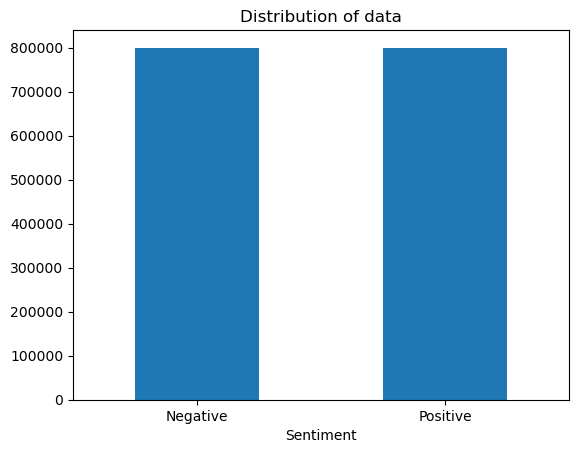

In [5]:
# Plotting the distribution of dataset
ax = DataFrame.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [6]:
# Defining dictionary containing all emojis with their meanings.
Emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Defining set containing all stopwords in english.
StopwordList = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [7]:
# Storing data in a list
Text, Sentiment = list(DataFrame['Text']), list(DataFrame['Sentiment'])

In [8]:
def Preprocess_Text(Text_Data):
    Processed_Text = []
    
    # Create Lemmatizer and Stemmer.
    Word_Lemmatizer = WordNetLemmatizer()
    
    # Defining regex patterns.
    url_Pattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_Pattern       = '@[^\s]+'
    alpha_Pattern      = "[^a-zA-Z0-9]"
    sequence_Pattern   = r"(.)\1\1+"
    seqReplace_Pattern = r"\1\1"
    
    for tweet in Text_Data:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(url_Pattern,' URL',tweet)
        # Replace all emojis.
        for emoji in Emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + Emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(user_Pattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alpha_Pattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequence_Pattern, seqReplace_Pattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = Word_Lemmatizer.lemmatize(word)
                tweetwords += (word+' ')
            
        Processed_Text.append(tweetwords)
        


    return Processed_Text


    

In [9]:
import nltk
#nltk.download()
import time
t = time.time()
ProcessedText = Preprocess_Text(Text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 66 seconds


In [10]:
#separacion de datos
X_train, X_test, y_train, y_test = train_test_split(ProcessedText, Sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [11]:
# Vectorización
Vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
Vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
vocabulary = Vectoriser.vocabulary_
print('No. of feature_words: ', len(vocabulary.keys()))

Vectoriser fitted.
No. of feature_words:  500000


In [12]:
X_train = Vectoriser.transform(X_train)
X_test  = Vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [13]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    Confusion_Matrix = confusion_matrix(y_test, y_pred)

    Categories  = ['Negativo','Positivo']
    GroupNames = ['Verdadero Neg','Falso Pos', 'Falso Neg','Verdadero Pos']
    GroupPercentages = ['{0:.2%}'.format(value) for value in Confusion_Matrix.flatten() / np.sum(Confusion_Matrix)]

    Labels = [f'{v1}\n{v2}' for v1, v2 in zip(GroupNames,GroupPercentages)]
    Labels = np.asarray(Labels).reshape(2,2)

    sns.heatmap(Confusion_Matrix, annot = Labels, cmap = 'Blues',fmt = '',
                xticklabels = Categories, yticklabels = Categories)

    plt.xlabel("Valores predichos", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Valores actuales"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Matriz de confusión", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



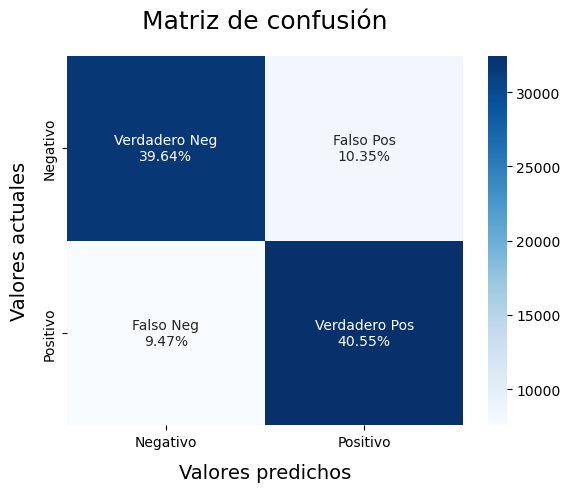

In [14]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

/home/slopez_25/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



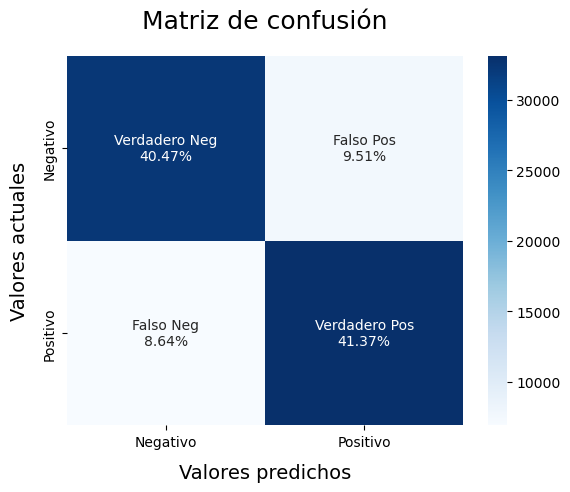

In [15]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



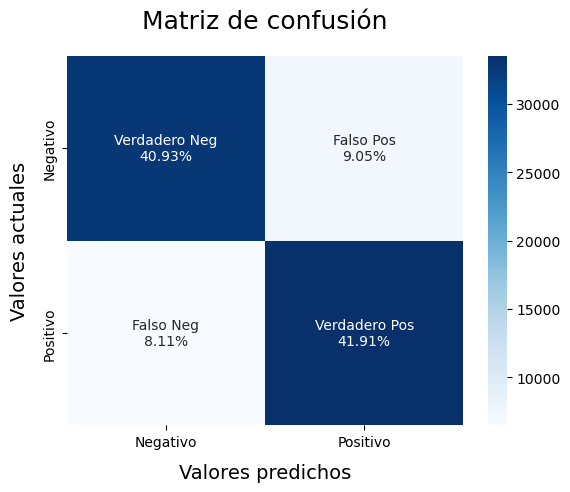

In [16]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [17]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(Vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [18]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    Vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return Vectoriser, LRmodel

def predict(Vectoriser, model, text):
    # Predict the sentiment
    textdata = Vectoriser.transform(Preprocess_Text(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["Oh, baby, how you doing?",
"You know I'ma cut right to the chase, huh",
"Some women were made",
"But me, myself",
"I like to think that I was created",
"For a special purpose",
"You know?",
"What's more special than you?",
"You feel me?",
"It's on baby, let's get lost",
"You don't need to call in to work 'cause you the boss",
"For real, want you to show me how you feel",
"I consider myself lucky that's a big deal",
"Why?",
"Well, you got the key to my heart",
"But you ain't gon' need it",
"I'd rather you open up my body",
"And show me secrets you didn't know was inside",
"No need for me to lie",
"It's too big (big)",
"It's too wide (wide)",
"It's too strong (strong)",
"It won't fit (fit)",
"It's too much (much)",
"It's too tough (tough)",
"He talk like this 'cause he can back it up",
"He got a big ego",
"Such a huge ego",
"I love his big ego",
"It's too much",
"He walk like this 'cause he can back it up, ha-ha",
"Usually I'm humble",
"Right now I don't choose",
"You can leave with me",
"Or you could have the blues",
"Some call it arrogant",
"I call it confident",
"You decide when you find",
"Out what I'm working with",
"Damn, I know I'm killing you with them legs",
"Better yet, them thighs",
"Matter of fact it's my smile or maybe my eyes",
"Boy, you're a sight to see, kinda somethin' like me",
"It's too big (big)",
"It's too wide (wide)",
"It's too strong (strong)",
"It won't fit (fit)",
"It's too much (much)",
"It's too tough (tough)",
"I talk like this 'cause I can back it up",
"I got a big ego",
"Such a huge ego",
"But he love my big ego",
"It's too much",
"I walk like this 'cause I can back it up",
"I, I walk like this 'cause I can back it up",
"I, I talk like this 'cause I can back it up",
"I, I, I can back it up",
"I can back it up",
"I walk like this 'cause I can back it up",
"It's too big (big)",
"It's too wide (wide)",
"It's too strong (strong)",
"It won't fit (fit)",
"It's too much (much)",
"It's too tough (tough)",
"He talk like this 'cause he can back it up",
"He got a big ego",
"Such a huge ego, such a huge ego",
"But I love his big ego",
"It's too much",
"He walk like this 'cause he can back it up",
"Ego so big you must admit",
"I got every reason to feel like I'm that bitch",
"Ego so strong, if you ain't know",
"I don't need no beat I can sing it with piano",
"Whoa, whoa, whoa",
"Whoa, whoa",
"Ah whoa, ohh",
"Ohh-oh, ohh-ooh-ooh"]
    
    df = predict(Vectoriser, LRmodel, text)
    print(df.head(25))

                                                 text sentiment
0                            Oh, baby, how you doing?  Positive
1           You know I'ma cut right to the chase, huh  Positive
2                                Some women were made  Positive
3                                      But me, myself  Negative
4                  I like to think that I was created  Positive
5                               For a special purpose  Positive
6                                           You know?  Positive
7                       What's more special than you?  Positive
8                                        You feel me?  Negative
9                        It's on baby, let's get lost  Positive
10  You don't need to call in to work 'cause you t...  Positive
11         For real, want you to show me how you feel  Negative
12          I consider myself lucky that's a big deal  Positive
13                                               Why?  Negative
14                  Well, you got the ke

In [19]:
df['sentiment'].values

array(['Positive', 'Positive', 'Positive', 'Negative', 'Positive',
       'Positive', 'Positive', 'Positive', 'Negative', 'Positive',
       'Positive', 'Negative', 'Positive', 'Negative', 'Positive',
       'Negative', 'Positive', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Negative', 'Negative', 'Negative',
       'Positive', 'Positive', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Negative', 'Negative', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Negative', 'Positive',
       'Positive', 'Negative', 'Negative', 'Negative', 'Positive',
       'Positive', 'Positive', 'Positive', 'Negative', 'Negative',
       'Negative', 'Positive', 'Positive', 'Positive', 'Negative',
       'Negative', 'Positive', 'Positive', 'Negative', 'Negative',
       'Negative', 'Positive', 'Positive', 'Positive', 'Positive',
       'Negative', 'Positive', 'Positive', 'Positive', 'Positi

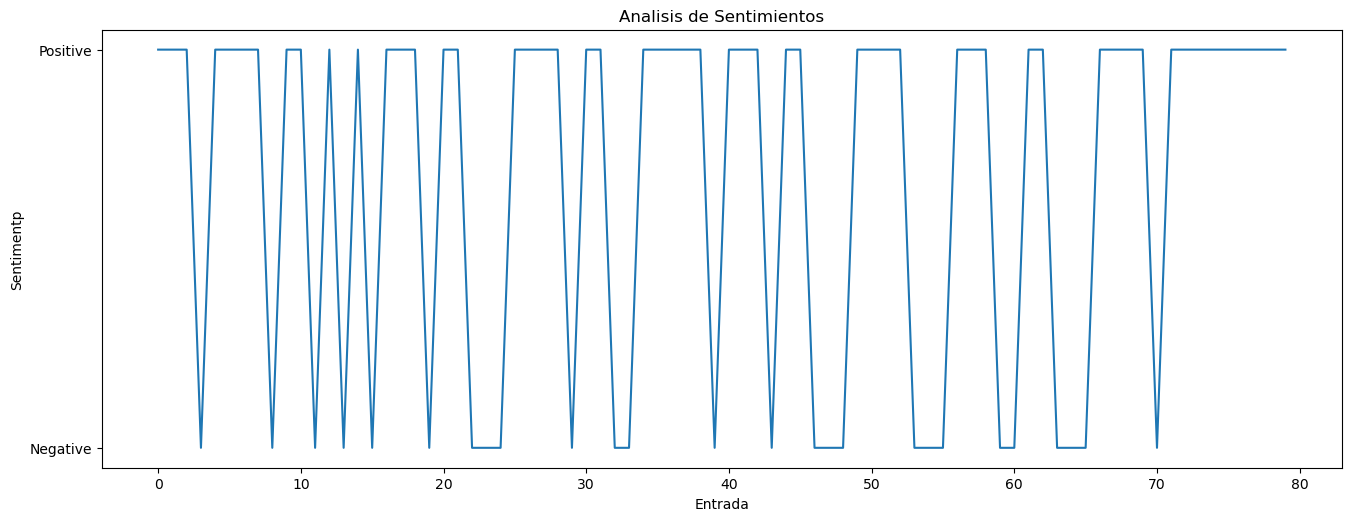

In [20]:
plt.figure(figsize=(16, 6))  # Ajustar el tamaño de la figura

plt.plot(df['text'].index.values, df['sentiment'].values)                                                                
plt.xlabel('Entrada')
plt.ylabel('Sentimentp')
plt.title('Analisis de Sentimientos')

plt.subplots_adjust(bottom=0.15)  # Ajustar los márgenes del gráfico
plt.gca().invert_yaxis()

plt.show()


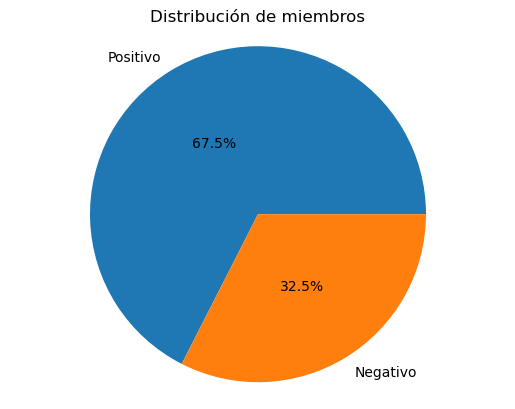

In [22]:
Positive = df['sentiment'].loc[df['sentiment'] == 'Positive']
Negative = df['sentiment'].loc[df['sentiment'] == 'Negative']

per_Positive = len(Positive)*100/float(len(df['sentiment']))
per_Negative = len(Negative)*100/float(len(df['sentiment']))

Labels = ['Positivo', 'Negativo']
Percentage = [per_Positive, per_Negative]
plt.figure()
plt.pie(Percentage, labels=Labels, autopct='%1.1f%%', pctdistance=0.5)

# Ajustar aspectos de la gráfica
plt.axis('equal')  # Hace que la gráfica sea un círculo en lugar de una elipse
plt.title('Distribución de miembros')

# Mostrar la gráfica
plt.show()